In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams.update({'figure.dpi': 300})

In [3]:
import numpy as np
from scipy.spatial import distance
from scipy.optimize import minimize
from numpy.random import multivariate_normal
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

### Define General Setting

In [4]:
d = 1000
N = 100

In [5]:
np.random.seed(1993)  # set seed for repetative results.

### Define Dataset (Woodworth et al.)

In [6]:
s = 5
noise_var = 0.01

X_train = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=N)
X_test = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=2000)
w_star = np.zeros(d)
support = np.random.choice(np.arange(d), s, replace=False)
w_star[support] = 1/np.sqrt(s)
y_train = np.dot(X_train, w_star) + np.sqrt(noise_var) * np.random.randn(N)
y_test = np.dot(X_test, w_star)

X_train = torch.DoubleTensor(X_train)
X_test = torch.DoubleTensor(X_test)
y_train = torch.DoubleTensor(y_train)
y_test = torch.DoubleTensor(y_test)

In [7]:
y_train.shape, X_train.shape

(torch.Size([100]), torch.Size([100, 1000]))

### Define FC Model

In [8]:
def symmetric_init(alpha, s, m, d, symmetric=True):
    """
    alpha = |a_0| + ||w_0||
    s = (|a_0| - ||w_0||) / (|a_0| + ||w_0||)
    """
    norms_w = []
    norms_a = []
    for alpha_i, s_i in zip(alpha, s):
        norm_w = np.sqrt(alpha_i * (1 - s_i) / (1 + s_i))
        norm_a = np.sqrt(alpha_i * (1 + s_i) / (1 - s_i))
        norms_w.append(norm_w)
        norms_a.append(norm_a)

    w_0 = np.random.normal(size=(m, d), loc=0, scale=1)
    w_0_norms = np.linalg.norm(w_0, axis=1, ord=2)
    w_0 = w_0 / w_0_norms[:, np.newaxis] * np.array(norms_w)[:, np.newaxis]

    a_0 = np.random.normal(size=(1, m), loc=0, scale=1)
    a_0 = np.multiply(np.ones_like(a_0) * np.array(norms_a), (1 * (a_0 > 0) - 0.5) * 2)

    if symmetric:
        w_0[m // 2:, :] = w_0[:m // 2, :]
        a_0[:, m // 2:] = -a_0[:, :m // 2]

    return w_0.transpose(), a_0.reshape(-1,)

In [9]:
class TwoLayerModel(nn.Module):
    def __init__(self, alpha, s, m, d, use_relu=False, symmetric=True):
        super(TwoLayerModel, self).__init__()

        self.w = nn.Parameter(torch.DoubleTensor(d, m))
        self.a = nn.Parameter(torch.DoubleTensor(m))

        if use_relu:
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()

        with torch.no_grad():
            # unbiased init
            w_0, a_0 = symmetric_init(alpha, s, m, d, symmetric=symmetric)
            self.w.data, self.a.data = torch.DoubleTensor(w_0), torch.DoubleTensor(a_0)
            self._w_0 = self.w.transpose(1, 0).clone().detach().numpy()
            self._a_0 = self.a.view(-1, 1).clone().detach().numpy()

    def forward(self, x):
        x = torch.matmul(x, self.w)
        x = self.activation(x)
        x = torch.mv(x, self.a)
        return x
    
    @property
    def current_w(self):
        return self.w.transpose(1, 0).detach().numpy()
    
    @property
    def current_a(self):
        return self.a.view(-1, 1).detach().numpy()

    @property
    def w_0(self):
        return self._w_0

    @property
    def a_0(self):
        return self._a_0
    
    
def train(alpha, s, m, d, step_size, use_relu=False, symmetric=True, early_stop_tol=1e-5, num_epochs=int(1e7)):
    model = TwoLayerModel(alpha=alpha, s=s, m=m, d=d, use_relu=use_relu, symmetric=symmetric)
    optimizer = torch.optim.SGD(model.parameters(), lr=step_size)

    w_tilde_array = []
    a_array = []
    w_tilde_array.append(model.current_w * model.current_a)  # get the initial state
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(X_train)
        loss = F.mse_loss(pred, y_train)
        loss.backward()
        optimizer.step()

        w_tilde_array.append(model.current_w * model.current_a)
        a_array.append(model.current_a.copy())
        if loss.item() < early_stop_tol:
            print(f'early stopping after {epoch + 1} epochs')
            break

    with torch.no_grad():
        test_loss = F.mse_loss(model(X_test), y_test)
    return model, loss, test_loss, w_tilde_array, a_array

### Define Q Function

$q\left(\mathbf{\tilde{w}}(t)\right)=\frac{\left(\left\Vert \mathbf{\tilde{w}}(t)\right\Vert ^{2}-\frac{\delta}{2}\left(\frac{\delta}{2}+\sqrt{\left\Vert \mathbf{\tilde{w}}(t)\right\Vert ^{2}+\frac{\delta^{2}}{4}}\right)\right)\sqrt{\sqrt{\left\Vert \mathbf{\tilde{w}}(t)\right\Vert ^{2}+\frac{\delta^{2}}{4}}-\frac{\delta}{2}}}{\left\Vert \mathbf{\tilde{w}}(t)\right\Vert }-\frac{3}{2}\sqrt{\sqrt{\left\Vert \mathbf{\tilde{w}}(0)\right\Vert ^{2}+\frac{\delta^{2}}{4}}-\frac{\delta}{2}}\frac{\mathbf{\tilde{w}}^{\top}(0)}{\left\Vert \mathbf{\tilde{w}}(0)\right\Vert }\mathbf{\tilde{w}}(t)$

In [10]:
def q(w_i, w_i_0, delta_i):
    d = delta_i/2
    norm_w_i = np.linalg.norm(w_i, ord=2)
    norm_w_i_0 = np.linalg.norm(w_i_0, ord=2)
    
    return (1/norm_w_i) * (norm_w_i**2 - d * (d + np.sqrt(norm_w_i**2 + d**2))) * np.sqrt(np.sqrt(norm_w_i**2 + d**2) - d)\
        - (3/2) * np.sqrt(np.sqrt(norm_w_i_0**2 + d**2) - d) * np.matmul(w_i_0.transpose(), w_i) / norm_w_i_0

In [11]:
def Q(w, w_0, delta):
    f = 0
    for w_i, w_i_0, delta_i in zip(w, w_0, delta):
        f += q(w_i, w_i_0, delta_i)
    return f

In [12]:
def flatten(w, a):
    return np.hstack([w.copy().flatten(), a.copy().flatten()])

def restore(v, m, d):
    w = v.copy()[: m * d].reshape(m, d)
    a = v.copy()[m * d:].reshape(m, 1)
    return w, a

In [13]:
def constraint(v, x, y, m, d):
    w, a = restore(v, m, d)
    w_tilde = w * a
    return (np.matmul(w_tilde, x.transpose()).sum(axis=0) - y).squeeze()

def constraint_relu(v, x, y, m, d):
    w, a = restore(v, m, d)
    y_pred = (np.maximum(np.matmul(w, x.transpose()), 0) * a).sum(axis=0)
    return (y_pred - y).squeeze()

def solver(x, y, w_0, a_0, alpha, s, obj='L1', optim_tol=1e-5, use_relu=False):
    x0 = flatten(w_0, a_0)

    if use_relu:
        cons = {'type': 'eq', 'fun': lambda v: constraint_relu(v, x, y, m, d)}
    else:
        cons = {'type': 'eq', 'fun': lambda v: constraint(v, x, y, m, d)}

    if obj == 'L1':
        objective = lambda v: np.linalg.norm(v, ord=2)
    elif obj == 'Q':
        delta = [4 * alpha_i * s_i / (1 - s_i**2) for alpha_i, s_i in zip(alpha, s)]
        w_tilde_0 = w_0 * a_0
        objective = lambda v: Q(restore(v, m, d)[0] * restore(v, m, d)[1] , w_tilde_0, delta)
    else:
        raise ValueError('objective not supported.')

    sol = minimize(
        fun=objective,
        x0=x0,
        constraints=cons,
        tol=optim_tol,
        method='SLSQP',
        options={
            'maxiter': 100000,
            'disp': False
        }
    )
    is_failed = (not sol.success)
    if is_failed:
        raise RuntimeError('Minimization Failed.')

    return restore(sol.x, m, d)

## Linear Single Neuron

In [67]:
m = 1
alpha_range = [0.01, 0.1]
s_range = [0, 0.5, 0.95]

In [69]:
results = {}
for s in s_range:
    for alpha in alpha_range:
        model, train_loss, test_loss, w_tilde_array, _ = train(
            alpha=[alpha],
            s=[s],
            m=m,
            d=d,
            step_size=1e-3,
            symmetric=False,
            early_stop_tol=1e-10)
        print(train_loss.item(), test_loss.item())
        results[(s, alpha)] = {'w_tilde_array': w_tilde_array, 'model': model}

early stopping after 2820 epochs
9.983135413083788e-11 0.8613107629090179
early stopping after 2376 epochs
9.945020701339457e-11 0.8932752667820523
early stopping after 2649 epochs
9.97057618792806e-11 0.8655543260772776
early stopping after 1762 epochs
9.991148157132719e-11 0.8907574299197731
early stopping after 1520 epochs
9.874759162189534e-11 0.859625827797062
early stopping after 223 epochs
9.731280678985564e-11 0.8703667605693315


In [74]:
# sanity check that GD learns
np.linalg.norm((model.w_0 *  model.a_0).flatten() - (model.current_w * model.current_a).flatten(), ord=2)

0.3253327198086305

0 0.01
0.5 0.01
0.95 0.01
0 0.1
0.5 0.1
0.95 0.1


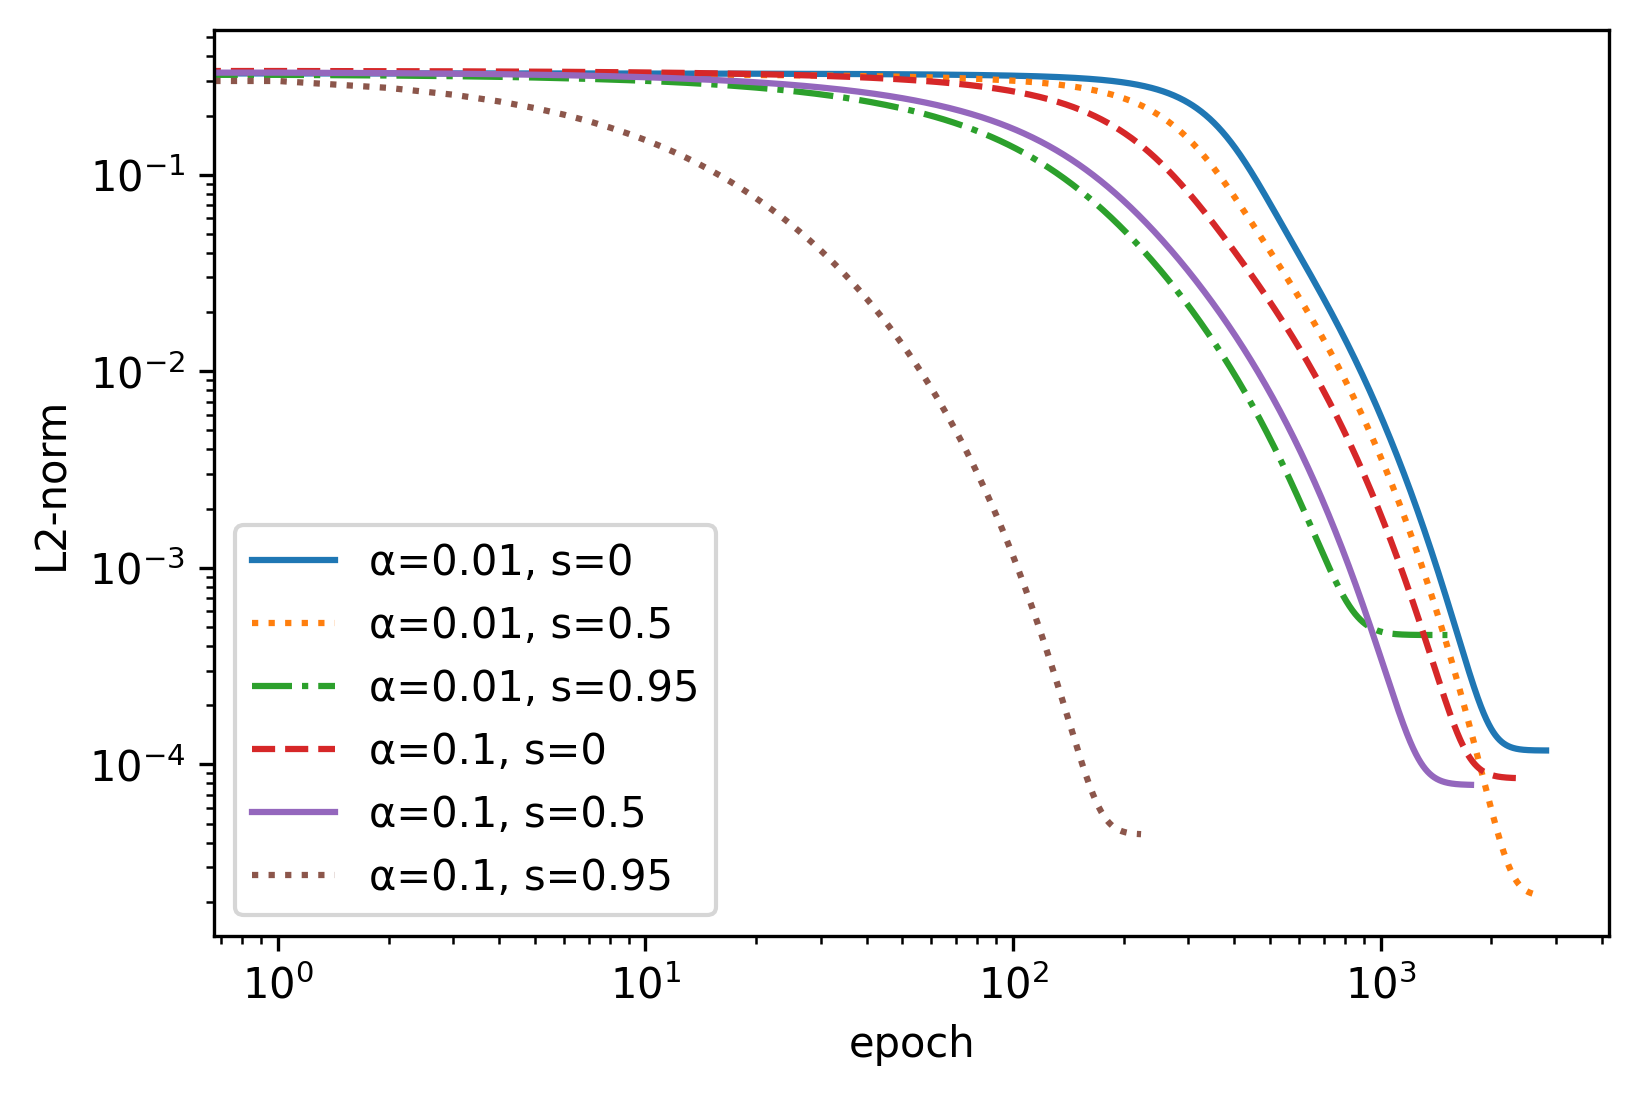

In [72]:
linstyles = ['', ':', '-.', '--']

legend_ = []
idx = 0
for alpha in alpha_range:
    for s in s_range:
        legend_.append(f'α={alpha}, s={s}')
        print(s, alpha)
        model = results[(s, alpha)]['model']
        w_tilde_array = results[(s, alpha)]['w_tilde_array']

        w_Q, a_Q = solver(X_train.numpy(), y_train.numpy(), model.w_0, model.a_0, alpha=[alpha], s=[s], obj='Q')
        w_tilde_Q = w_Q * a_Q

        plot([np.linalg.norm(w_tilde.flatten() - w_tilde_Q.flatten(), ord=2)
             for w_tilde in w_tilde_array], linstyles[idx % len(linstyles)])

        idx += 1
    
ylabel('L2-norm')
xlabel('epoch')
xscale('log')
yscale('log')
legend(legend_)

In [73]:
np.linalg.norm(w_tilde_Q.flatten() - w_tilde_array[-1].flatten(), ord=2)

4.4150942027785675e-05

## The  Case of $\delta < 0$ 

In [43]:
m = 1
alpha = [0.1] * m
s = [-0.9] * m

In [119]:
model, train_loss, test_loss, w_tilde_array, a_array = train(
    alpha=alpha,
    s=s,
    m=m,
    d=d,
    step_size=1e-3,
    symmetric=False,
    early_stop_tol=1e-10)
train_loss.item(), test_loss.item()

early stopping after 4812 epochs


(9.951565617752658e-11, 1.2882924071505855)

In [120]:
model.a_0, model.current_a

(array([[0.07254763]]), array([[-0.48887553]]))

In [121]:
assert np.sign(model.a_0) != np.sign(model.current_a)

In [122]:
# sanity check that GD learns
np.linalg.norm((model.w_0 *  model.a_0).flatten() - (model.current_w * model.current_a).flatten(), ord=2)

0.8012878645452366

In [123]:
w_Q, a_Q = solver(X_train.numpy(), y_train.numpy(), model.w_0, model.a_0, alpha=alpha, s=s, obj='Q')
w_tilde_Q = w_Q * a_Q

In [124]:
np.linalg.norm(w_tilde_Q.flatten() - w_tilde_array[-1].flatten(), ord=2)

1.272521713958592

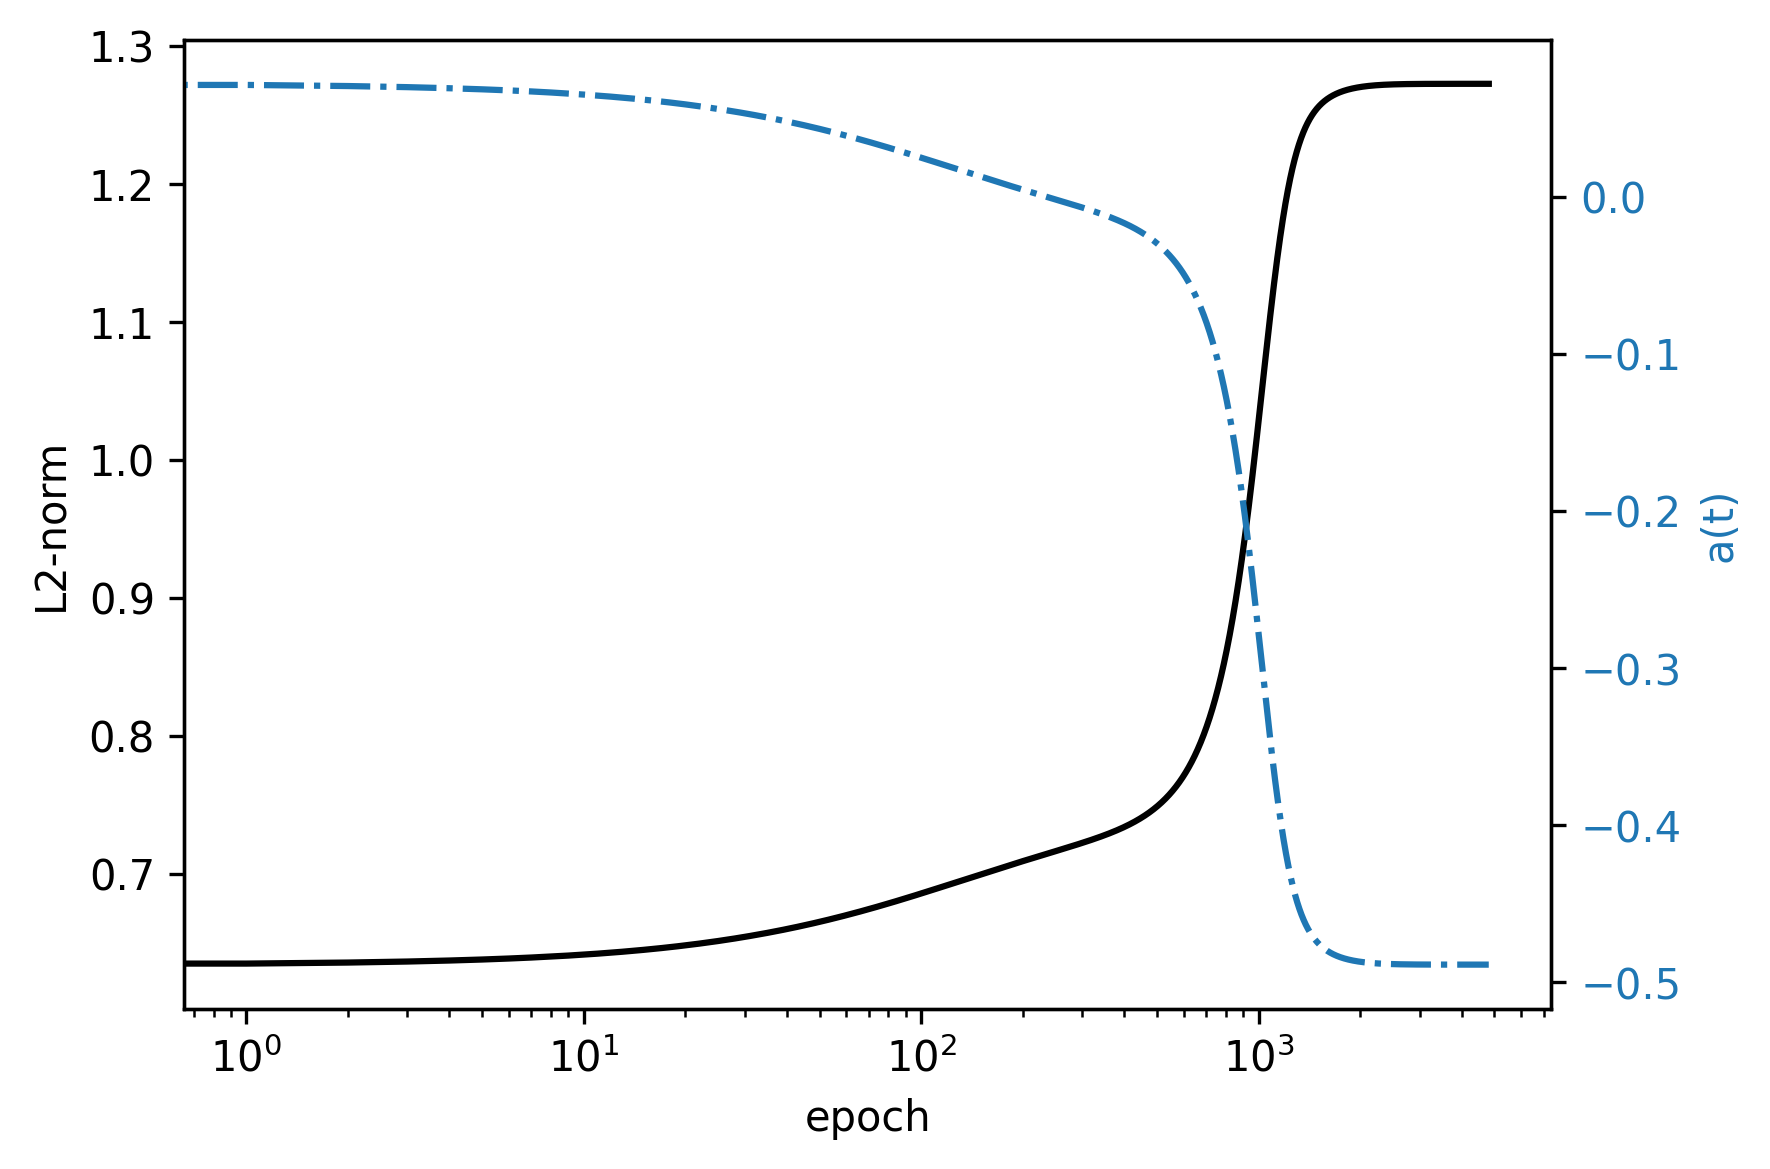

In [126]:
l2_norms = [np.linalg.norm(w_tilde.flatten() - w_tilde_Q.flatten(), ord=2) for w_tilde in w_tilde_array]
a_norms = [(a[0]) for a in a_array]

fig, ax1 = plt.subplots()

color = 'k'
ax1.set_xlabel('epoch')
ax1.set_ylabel('L2-norm', color=color)
ax1.plot(l2_norms, 'k')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('a(t)', color=color)
ax2.plot(a_norms, '-.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

xscale('log')
# yscale('log')

fig.tight_layout()
plt.show()

## Linear Multi Neuron

In [277]:
m = 10
alpha = [0.001] * m
s = [0.5] * m

In [278]:
model, train_loss, test_loss, w_tilde_array, _ = train(
    alpha=alpha, 
    s=s, 
    m=m, 
    d=d, 
    step_size=1e-3, 
    symmetric=False,
    early_stop_tol=1e-10
)
train_loss.item(), test_loss.item()

early stopping after 2665 epochs


(9.944327925843571e-11, 0.861698561001411)

In [279]:
# sanity check that GD learns
distance.cosine((model.w_0 *  model.a_0).flatten(), (model.current_w * model.current_a).flatten())

0.8954537946877957

In [ ]:
w_Q, a_Q = solver(X_train.numpy(), y_train.numpy(), model.w_0, model.a_0, alpha=alpha, s=s, obj='Q', optim_tol=1e-7)
w_tilde_Q = w_Q * a_Q

In [ ]:
distance.cosine(w_tilde_Q.flatten(), w_tilde_array[-1].flatten())

In [ ]:
plot([distance.cosine(w_tilde.flatten(), w_tilde_Q.flatten())
         for w_tilde in w_tilde_array])

title(f'm = {m}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')
xscale('log')
yscale('log')

In [ ]:
linstyles = ['', ':', '-.', '--']
fig, ax1 = plt.subplots()

color = 'k'
ax1.set_xlabel('epoch')
ax1.set_ylabel('L2-norm (distance)', color=color)
ax1.plot([np.linalg.norm(w_tilde.flatten() - w_tilde_Q.flatten(), ord=2) for w_tilde in w_tilde_array], 'k')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('L2-norm', color=color)
for i in range(m):
    plot([np.linalg.norm(w_tilde[i, :], ord=2) for w_tilde in w_tilde_array], linstyles[i % len(linstyles)], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend([f'$\tilde w_{i+1}$' if i < 9 else '$w_{10}$' for i in range(m)])

xscale('log')
yscale('log')

fig.tight_layout()
plt.show()

#### Evolution of the Norm

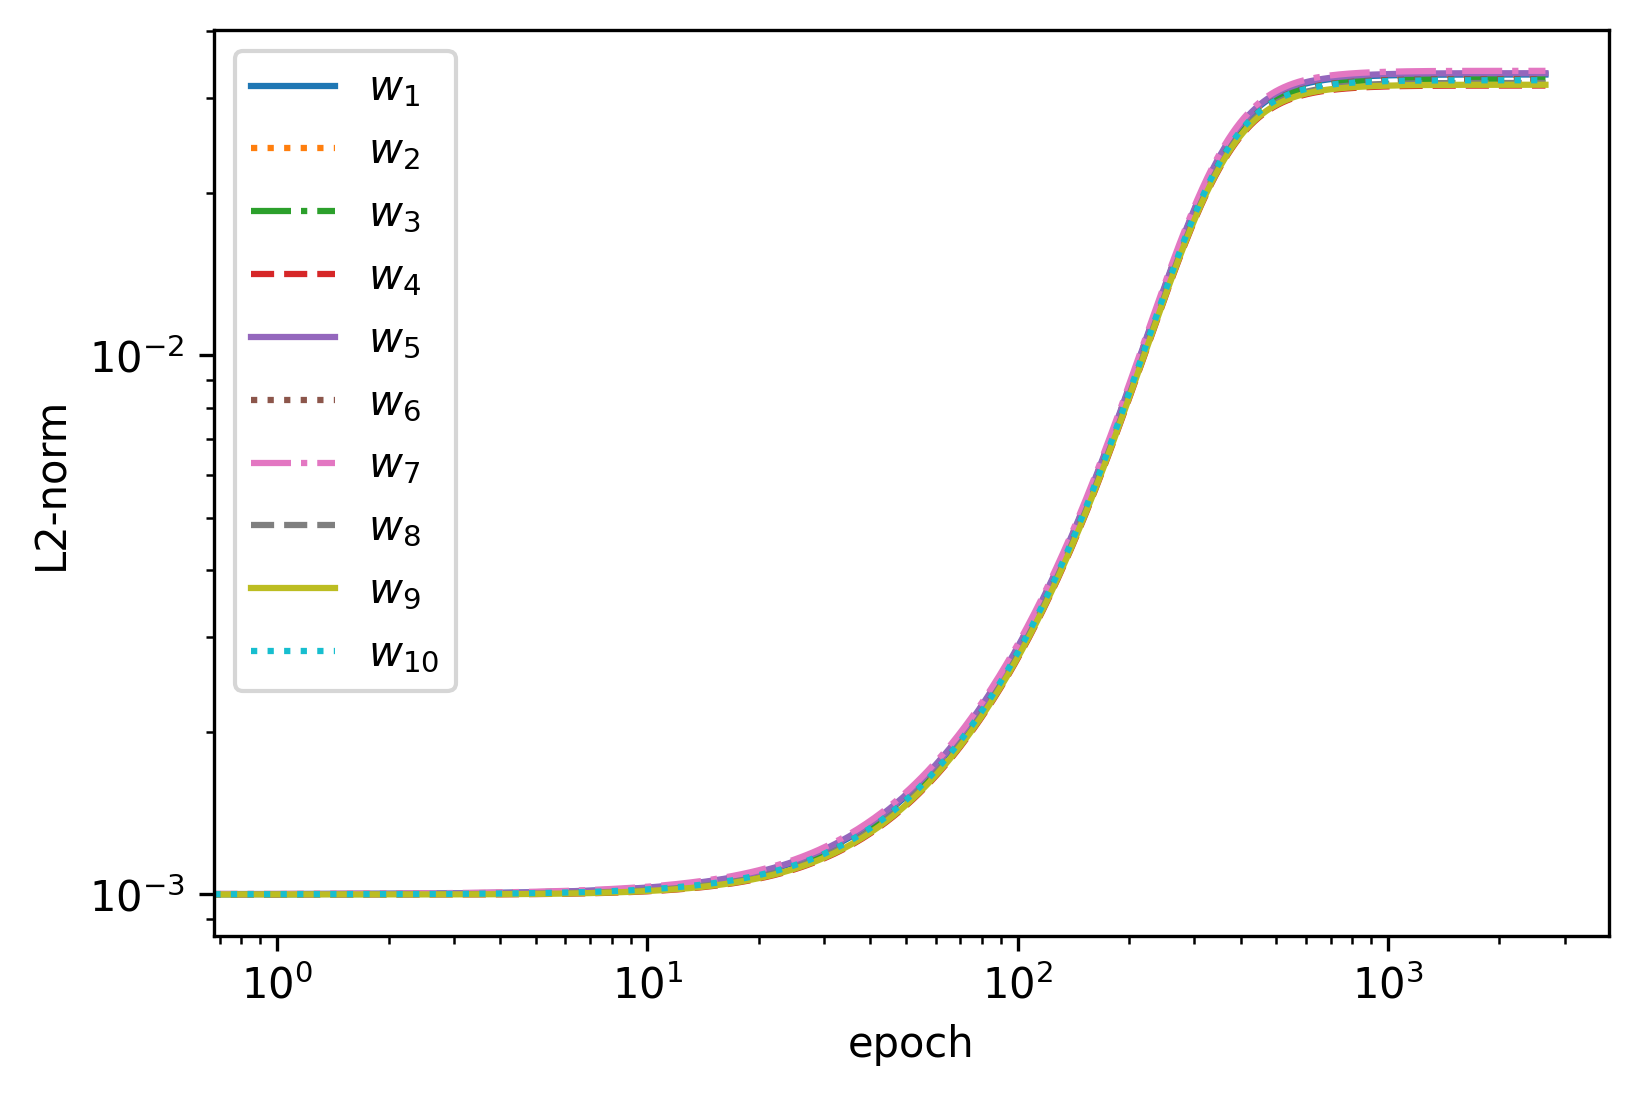

In [33]:
linstyles = ['', ':', '-.', '--']

for i in range(m):
    plot([np.linalg.norm(w_tilde[i, :], ord=2) for w_tilde in w_tilde_array], linstyles[i % len(linstyles)])
    
ylabel('L2-norm')
xlabel('epoch')
xscale('log')
yscale('log')


## Effect of Shape and Scale

In [234]:
def angle(v, u):
    return np.arccos(np.dot(v / np.linalg.norm(v), u / np.linalg.norm(u)))

In [235]:
baseline = np.random.normal(size=(d,))
baseline.shape

(1000,)

In [236]:
alpha_range = np.logspace(-4, -2, 3)
s_range = [0, 0.5, 0.95]

In [237]:
m = 100

In [262]:
results = {}
for alpha in alpha_range:
    for s in s_range:
        print(alpha, s)
        model, train_loss, test_loss, w_tilde_array, _ = train(
            alpha=[alpha] * m, 
            s=[s]* m, 
            m=m, 
            d=d, 
            step_size=1e-3, 
            symmetric=False,
            early_stop_tol=1e-10
        )
        results[(s, alpha)] = model.current_w.copy()

0.0001 0
early stopping after 2817 epochs
0.0001 0.5
early stopping after 2663 epochs
0.0001 0.95
early stopping after 1522 epochs
0.001 0
early stopping after 2339 epochs
0.001 0.5
early stopping after 1719 epochs
0.001 0.95
early stopping after 223 epochs
0.01 0
early stopping after 803 epochs
0.01 0.5
early stopping after 290 epochs
0.01 0.95
early stopping after 19 epochs


Text(0.5, 0, 'α')

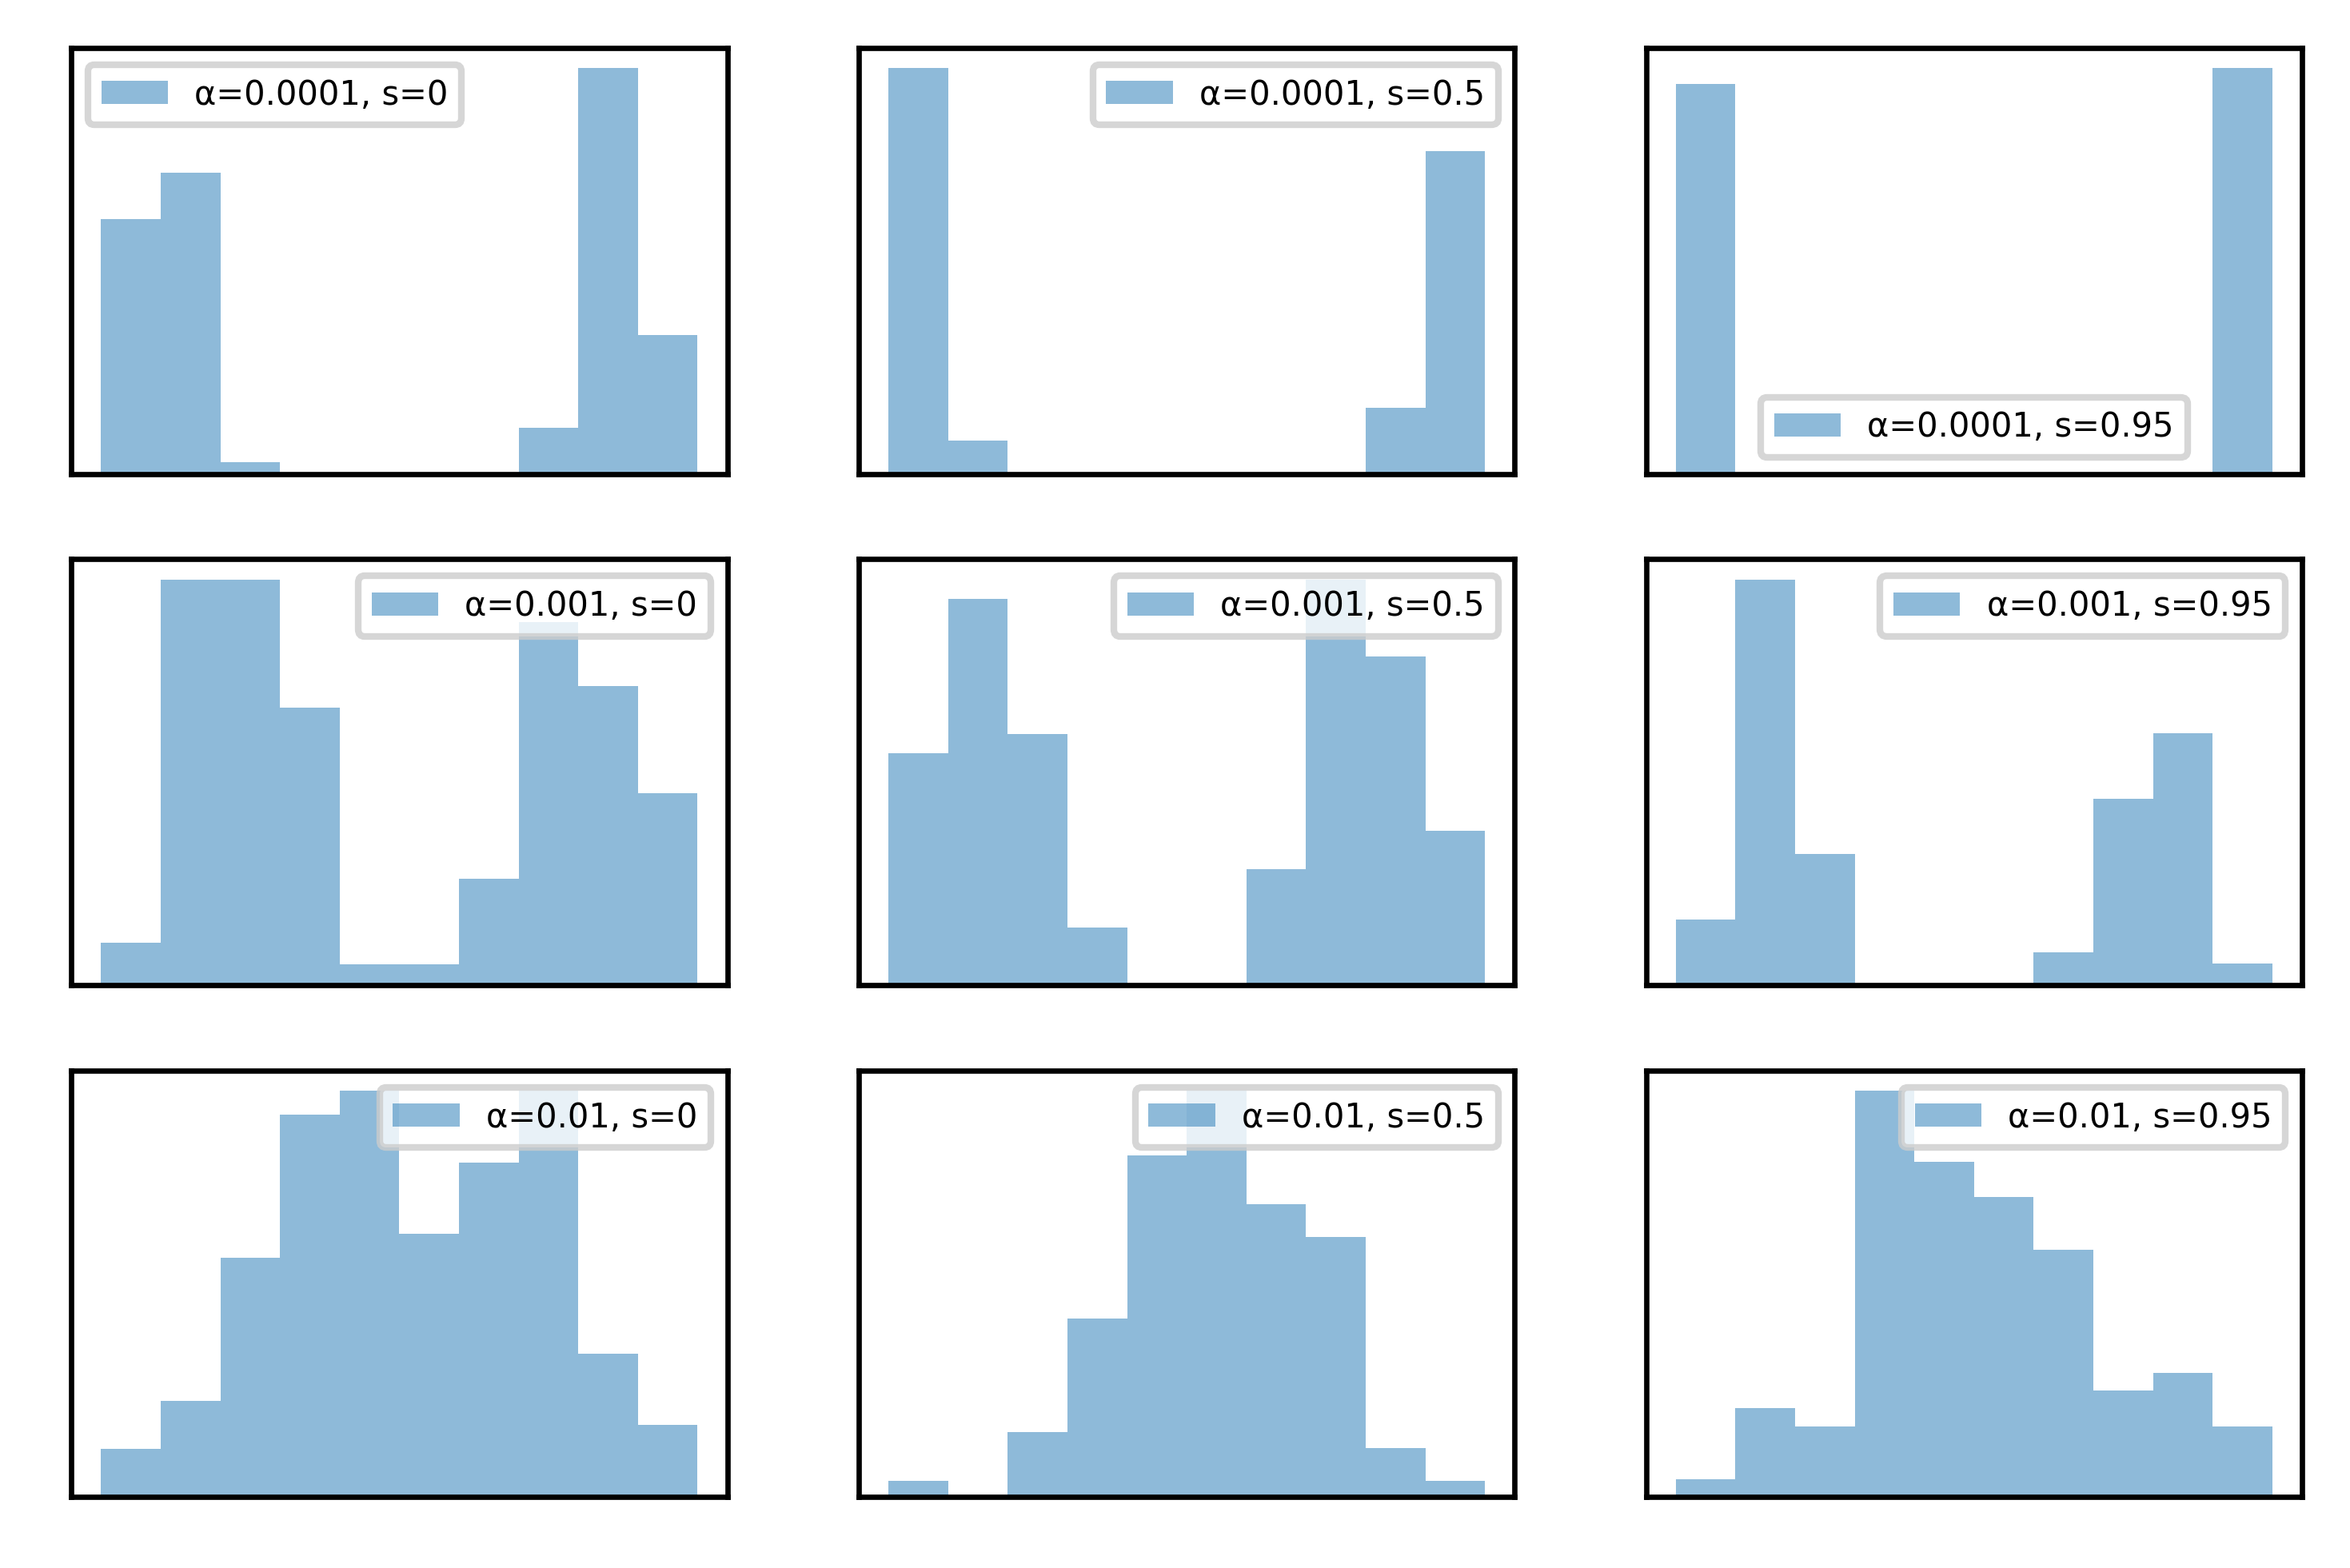

In [263]:
fig, axes = plt.subplots(len(alpha_range),len(s_range))
axes = axes.ravel()

idx = 0
for alpha in alpha_range:
    for s in s_range:
        ax = axes[idx]
        w = results[(s, alpha)]
        ax.hist([angle(w_i, baseline) for w_i in w], alpha=0.5)
        ax.legend([f'α={alpha}, s={s}'], fontsize=5)
        #ax.set_xlim([1.45, 1.7])
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
        
        idx += 1

##  Linear Multi Network [with different shapes]

In [264]:
m = 3
alpha = [0.01] * m
s = [0, 0.5, 0.9]

In [265]:
model, train_loss, test_loss, w_tilde_array, _ = train(
    alpha=alpha, 
    s=s, 
    m=m, 
    d=d, 
    step_size=1e-3, 
    symmetric=False,
    early_stop_tol=1e-10
)
train_loss.item(), test_loss.item()

early stopping after 1902 epochs


(9.955813849968431e-11, 0.8608212695585918)

In [266]:
# sanity check that GD learns
np.linalg.norm((model.w_0 *  model.a_0).flatten() - (model.current_w * model.current_a).flatten(), ord=2)

0.2698731394001577

In [267]:
w_Q, a_Q = solver(X_train.numpy(), y_train.numpy(), model.w_0, model.a_0, alpha=alpha, s=s, obj='Q', optim_tol=1e-7)
w_tilde_Q = w_Q * a_Q

In [268]:
y_pred_Q = (np.matmul(w_Q * a_Q, X_train.numpy().transpose())).sum(axis=0)
loss_Q = F.mse_loss(torch.DoubleTensor(y_pred_Q), y_train)
loss_Q.item()

1.432817343387185e-19

In [269]:
np.linalg.norm(w_tilde_Q.flatten() - w_tilde_array[-1].flatten(), ord=2)

0.14868662248284806

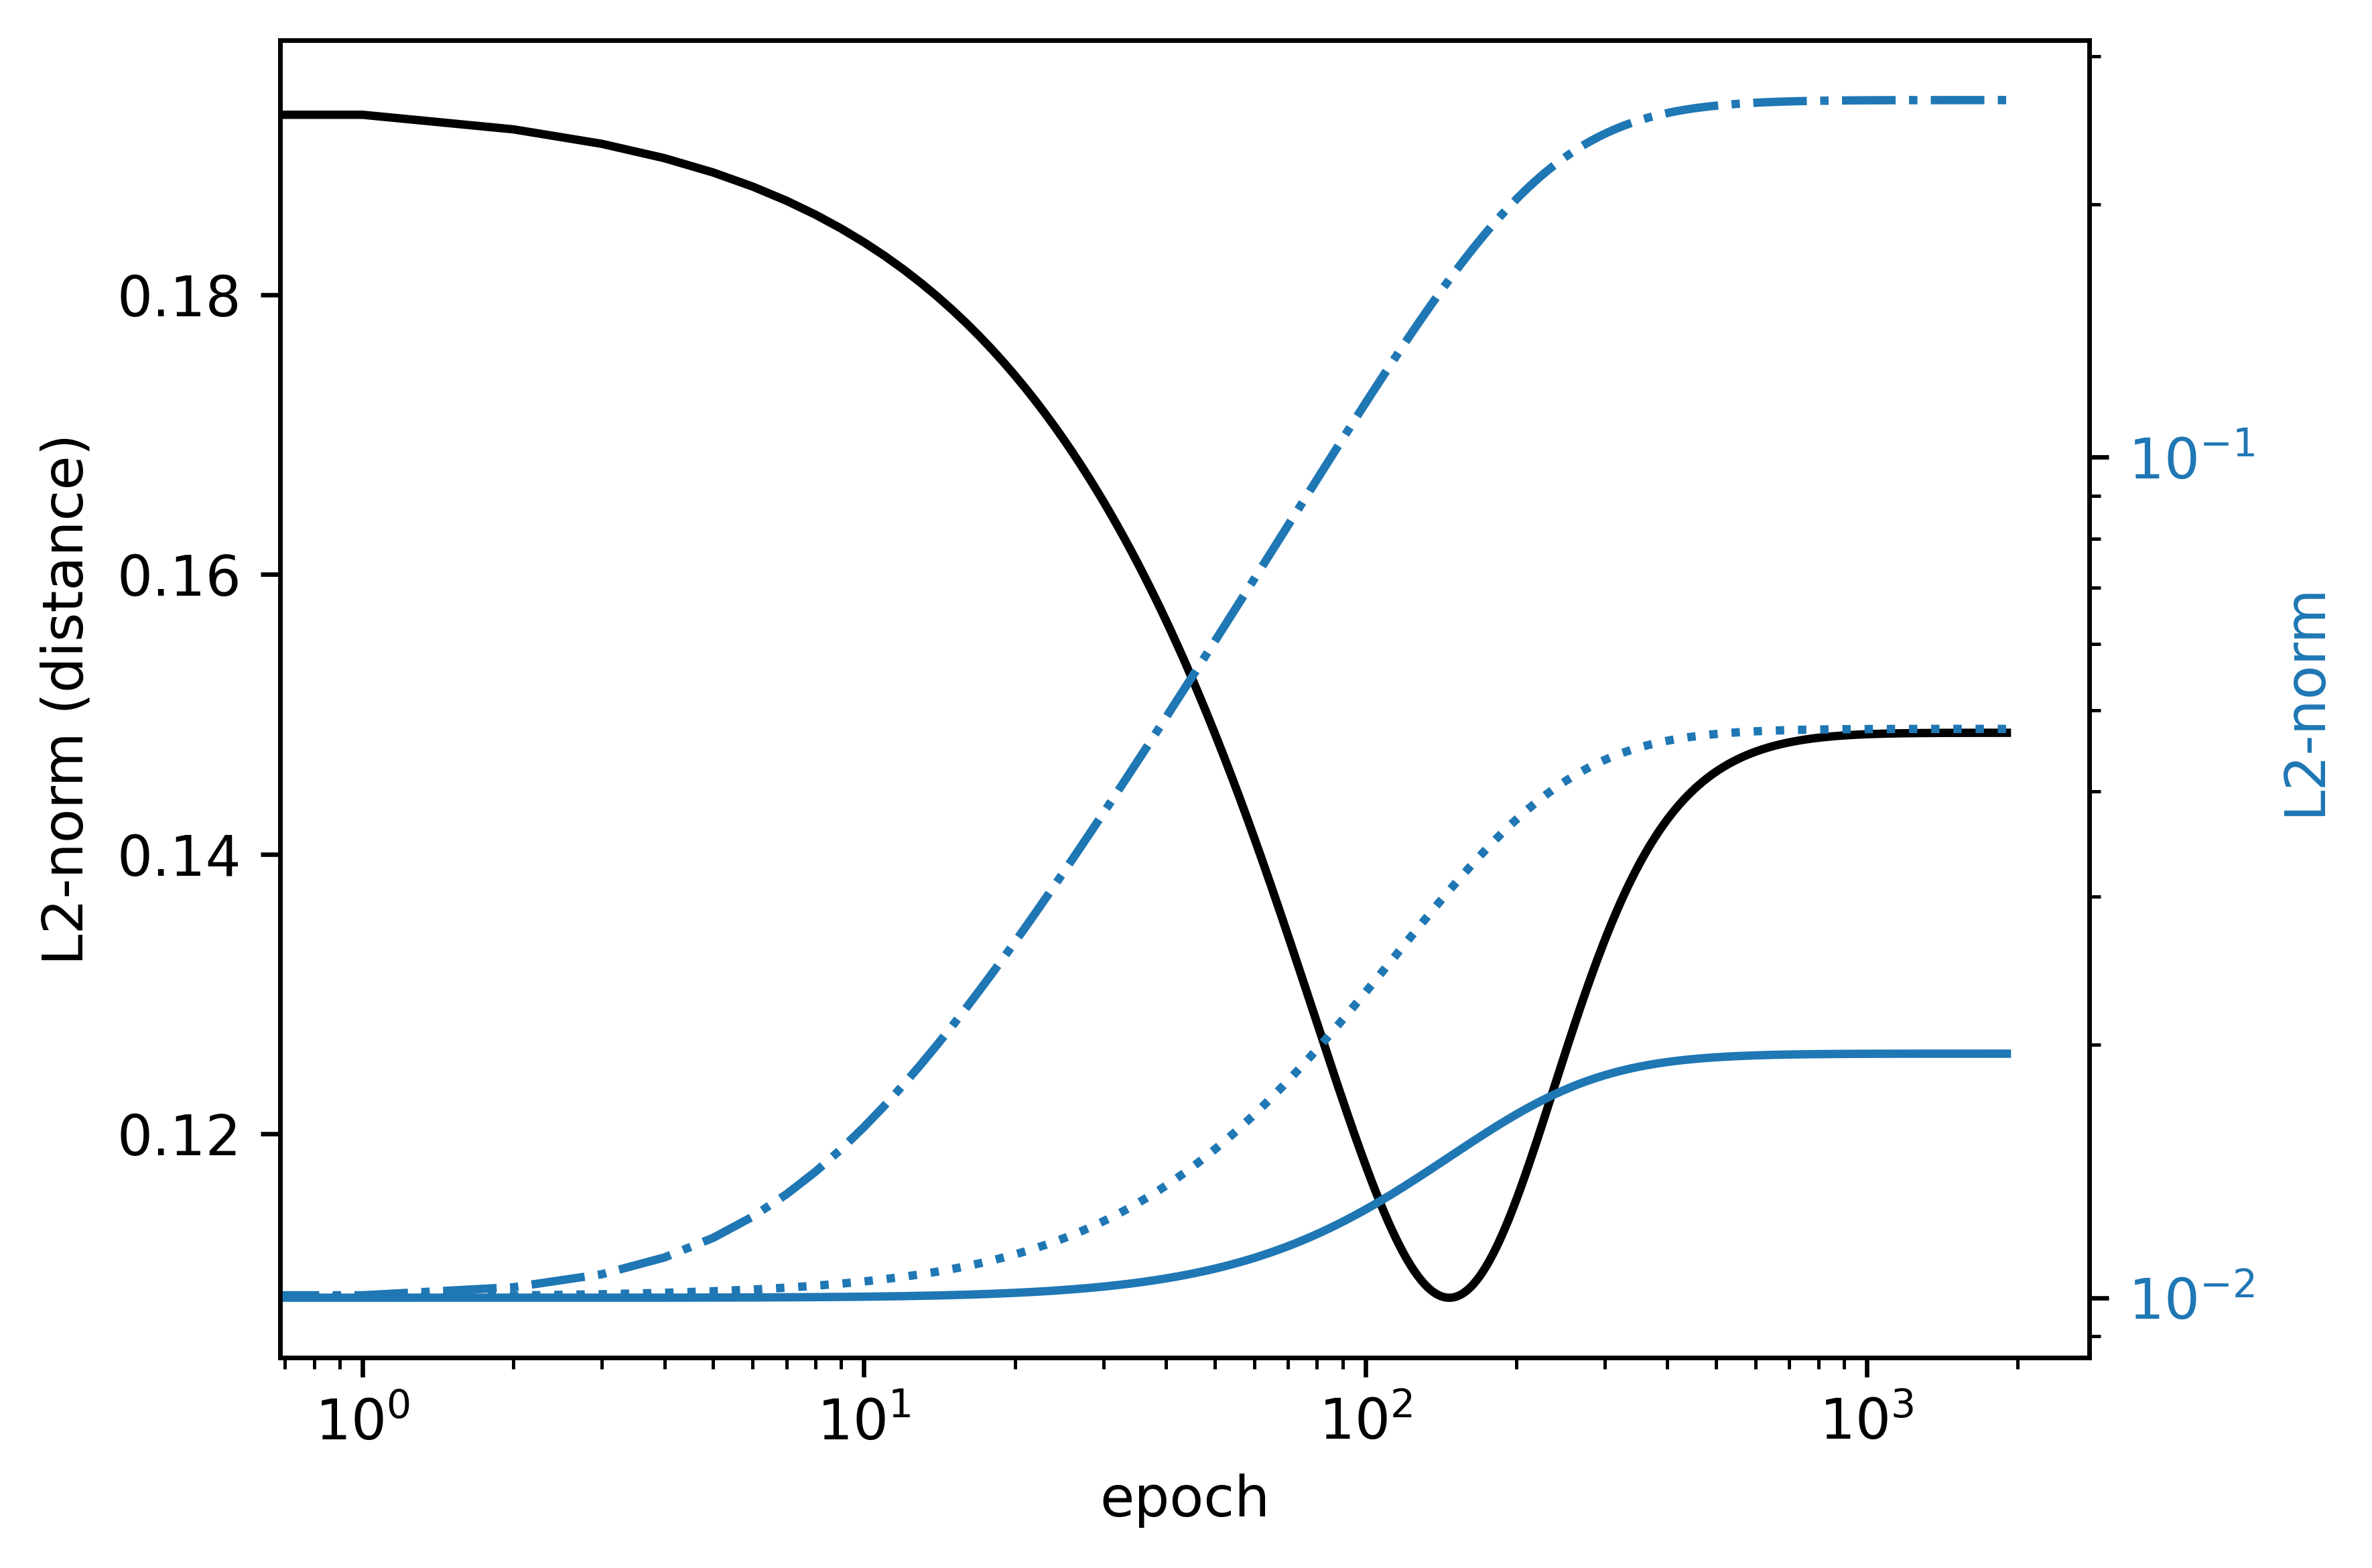

In [276]:
linstyles = ['', ':', '-.', '--']
fig, ax1 = plt.subplots()

color = 'k'
ax1.set_xlabel('epoch')
ax1.set_ylabel('L2-norm (distance)', color=color)
ax1.plot([np.linalg.norm(w_tilde.flatten() - w_tilde_Q.flatten(), ord=2) for w_tilde in w_tilde_array], 'k')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('L2-norm', color=color)
for i in range(m):
    plot([np.linalg.norm(w_tilde[i, :], ord=2) for w_tilde in w_tilde_array], linstyles[i % len(linstyles)], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend([f'$w_{i+1}$' for i in range(m)])

xscale('log')
yscale('log')

fig.tight_layout()
plt.show()

## Non-Linear

In [382]:
d = 5
N = 5

In [383]:
m = 10
alpha = 1
s = 0.5

### Define dataset based on teacher network

In [416]:
teacher = TwoLayerModel(alpha=alpha, s=0.3, m=m, d=d, use_relu=True, symmetric=False)

In [417]:
X_train = torch.DoubleTensor(np.random.normal(size=(N, d), scale=1))
y_train = teacher(X_train).detach()

X_train.shape, y_train.shape

(torch.Size([5, 5]), torch.Size([5]))

In [418]:
y_train

tensor([0.0183, 0.9858, 0.6131, 3.7395, 4.8489], dtype=torch.float64)

In [419]:
def train(alpha, s, m, d, step_size, use_relu=False, symmetric=True, early_stop_tol=1e-5, num_epochs=int(1e7)):
    model = TwoLayerModel(alpha=alpha, s=s, m=m, d=d, use_relu=use_relu, symmetric=symmetric)
    optimizer = torch.optim.SGD(model.parameters(), lr=step_size)

    w_tilde_array = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        pred = model(X_train)
        loss = F.mse_loss(pred, y_train)
        loss.backward()
        optimizer.step()

        w_tilde_array.append(model.current_w * model.current_a)
        if loss.item() < early_stop_tol:
            print(f'early stopping after {epoch + 1} epochs')
            break

    return model, loss, test_loss, w_tilde_array

In [420]:
model, train_loss, test_loss, w_tilde_array = train(
    alpha=alpha,
    s=s, 
    m=m, 
    d=d, 
    step_size=1e-3,
    symmetric=False,
    early_stop_tol=1e-20,
    use_relu=True)
train_loss.item(), test_loss.item()

early stopping after 12089 epochs


(9.976091363500525e-21, 0.9031829192347001)

In [421]:
# sanity check that GD learns
distance.cosine((model.w_0 *  model.a_0).flatten(), (model.current_w * model.current_a).flatten())

0.06625387972583263

In [422]:
w_Q, a_Q = solver(
    X_train.numpy(),
    y_train.numpy(),
    model.w_0,
    model.a_0,
    alpha=alpha,
    s=s, 
    obj='Q',
    use_relu=True,
    optim_tol=1e-7
)
w_tilde_Q = w_Q * a_Q

In [423]:
y_pred_Q = (np.maximum(np.matmul(w_Q, X_train.numpy().transpose()), 0) * a_Q).sum(axis=0)
loss_Q = F.mse_loss(torch.DoubleTensor(y_pred_Q), y_train)
loss_Q.item()

1.7278666917100321e-15

In [424]:
distance.cosine(w_tilde_Q.flatten(), w_tilde_array[-1].flatten())

0.0003588363961891661

In [425]:
# distance to teacher
distance.cosine((teacher.current_w *  teacher.current_a).flatten(), (model.current_w * model.current_a).flatten())

0.8720508423983806

In [426]:
distance.cosine((teacher.w_0 *  teacher.a_0).flatten(), (w_Q * a_Q).flatten())

0.8742812642317814

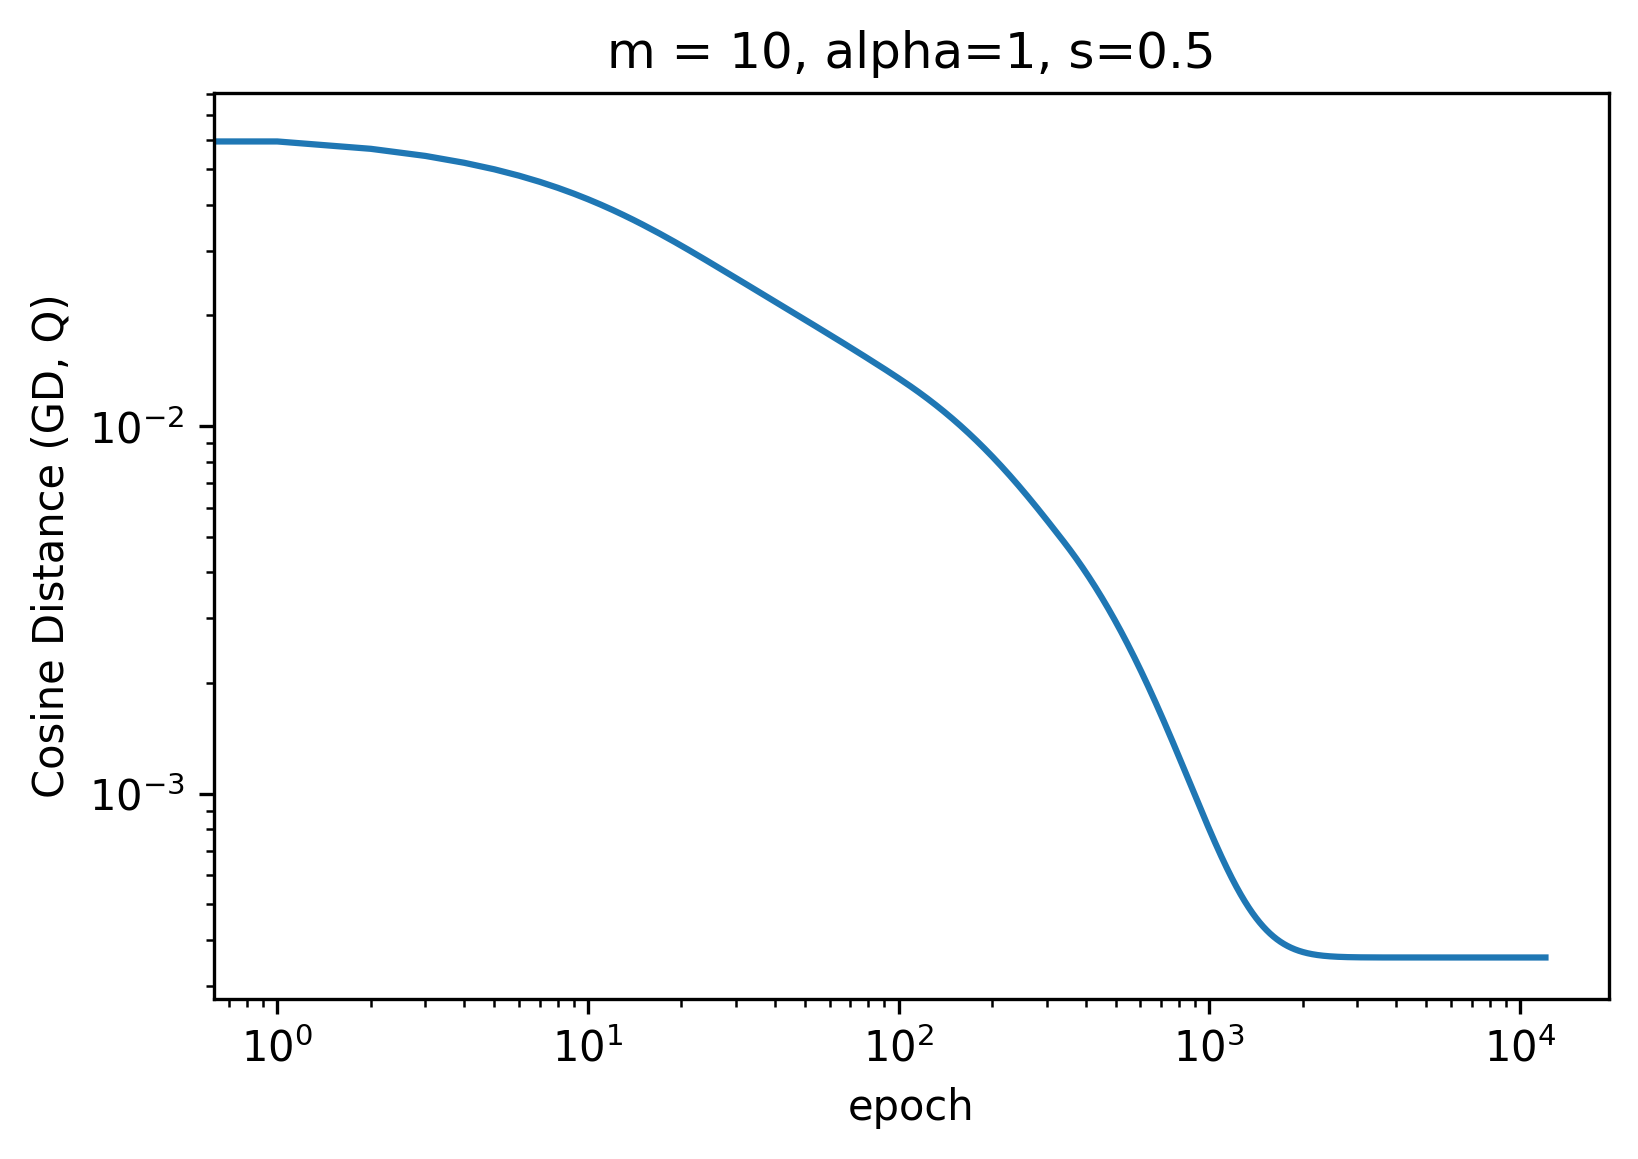

In [427]:
plot([distance.cosine(w_tilde.flatten(), w_tilde_Q.flatten())
         for w_tilde in w_tilde_array])

title(f'm = {m}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')
xscale('log')
yscale('log')

### Activation Pattern Analysis

In [428]:
c_i_0 = np.matmul(model.w_0, X_train.numpy().transpose()) > 0 
c_i_current = np.matmul(model.current_w, X_train.numpy().transpose()) > 0 
c_i_teacher = c_i_teacher = np.matmul(teacher.current_w, X_train.numpy().transpose()) > 0 
c_i_Q = np.matmul(w_Q, X_train.numpy().transpose()) > 0 

In [429]:
sum(c_i_current == c_i_0) / (m * N)

0.82

In [430]:
sum(c_i_current == c_i_teacher) / (m * N)

0.54

In [431]:
sum(c_i_current == c_i_Q) / (m * N)

0.94

### Visualize Q function (d = 2)

In [127]:
def q_hat(x, delta_i):
    d = delta_i/2
    
    return (1/x) * (x**2 - d * (d + np.sqrt(x**2 + d**2))) * np.sqrt(np.sqrt(x**2 + d**2) - d)

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


([], <a list of 0 Text major ticklabel objects>)

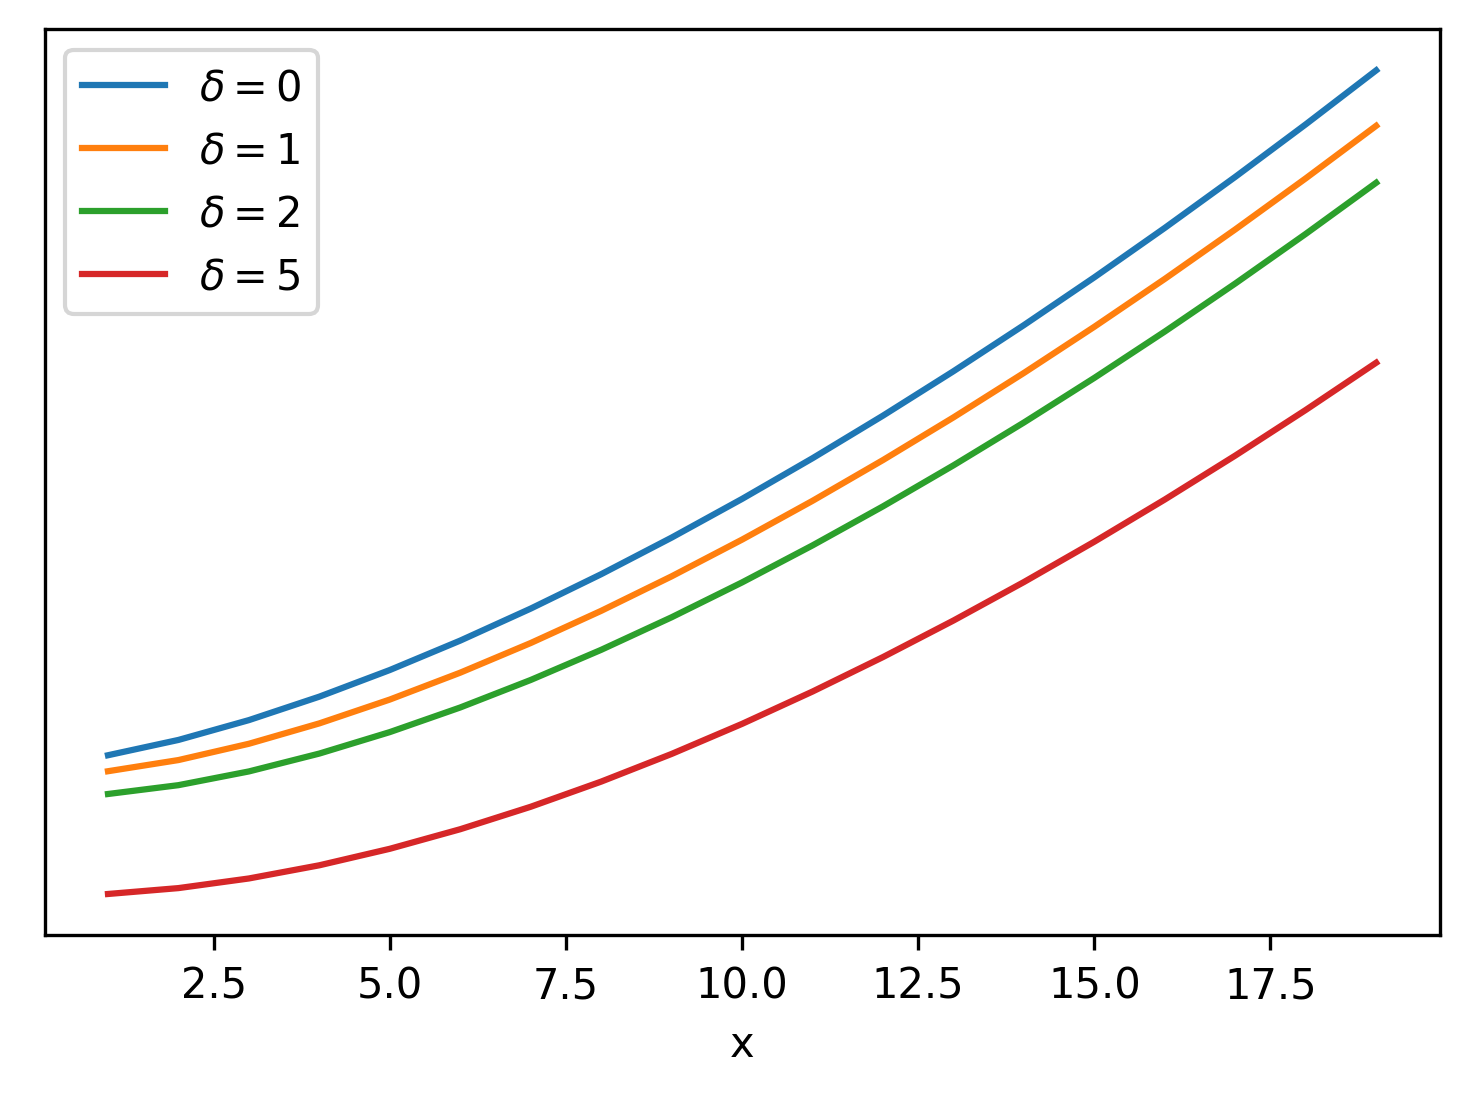

In [148]:
linstyles = ['', ':', '-.', '--']

x_range = np.arange(0, 10, 0.5)
delta_range = [0, 1, 2, 5]

for delta_i in delta_range:
    plot(list(map(lambda x: q_hat(x, delta_i), x_range)))
    
ylabel('')
xlabel('x')
legend([f'$\delta = {delta_i}$' for delta_i in delta_range])
plt.yticks([])

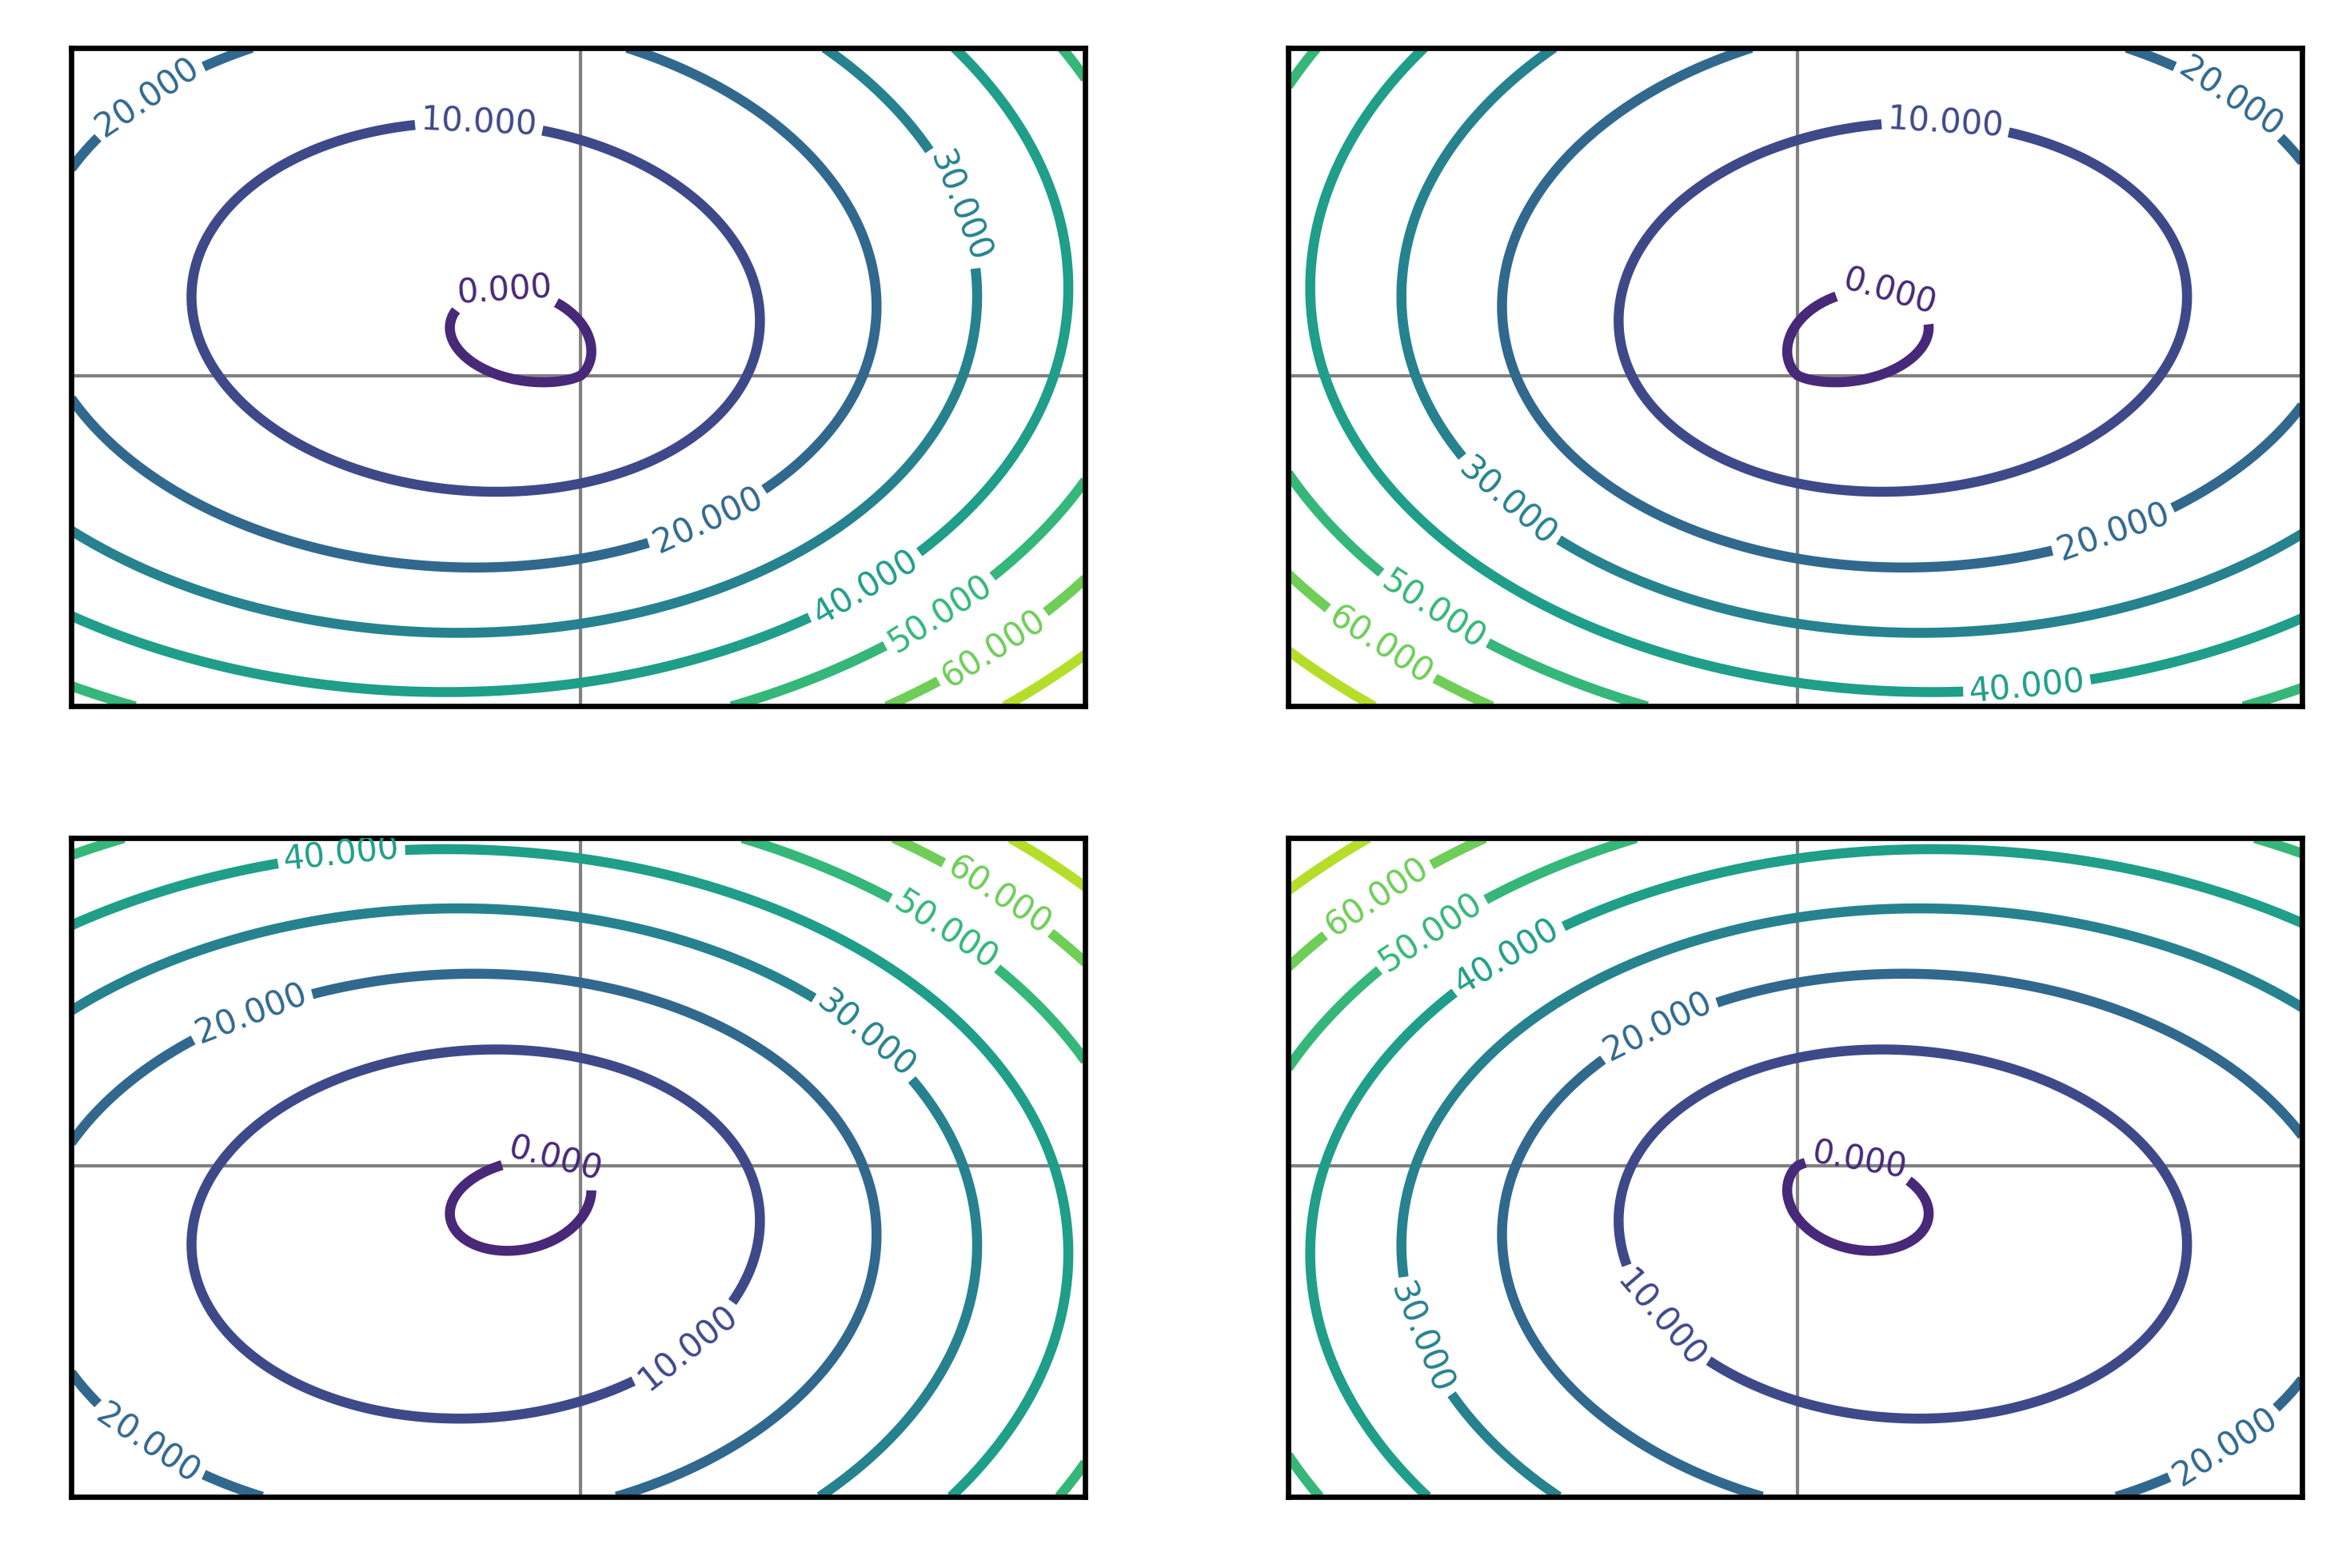

In [233]:
delta = 0
w1 = np.arange(-10.0, 10.0, 0.1)
w2 = np.arange(-10.0, 10.0, 0.1)

Z = np.zeros((len(w1), len(w2)))

fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

w_0 = [np.array([1, -1]), np.array([1, 1]), np.array([-1, -1]), np.array([-1, 1])]

for ax_idx, w_0_i in enumerate(w_0):
    for i, w1_i in enumerate(w1):
        for j, w2_j in enumerate(w2):
            w = np.array([w1_i, w2_j])
            z_value = q(w, w_0_i, delta)
            Z[i, j] = z_value

    ax = axes[ax_idx]
    CS = ax.contour(Z)
    ax.axhline(y=100, xmin=0, xmax=200, c='grey', linewidth=0.5, zorder=0)
    ax.axvline(x=100, ymin=0, ymax=200, c='grey', linewidth=0.5, zorder=0)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.clabel(CS, inline=1, fontsize=5)